In [1]:
import numpy as np
import seaborn as sns
sns.set()

In [2]:
# import the necessary keras packages
from sklearn.preprocessing import LabelEncoder
from loader_util.io import HDF5DatasetWriter
##
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.utils import plot_model
from imutils import paths
import progressbar
import random
import os

In [3]:
data_dir = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH\DeepLearning\DeepLearning-DL4CV\ImageDatasets\all_cats_dogs"
args = {
    "dataset": f"{data_dir}",
    "output": f"{data_dir}//hdf5//extracted_features.hdf5",
    "batch_size": 16,
    "buffer_size": 1000
}

# store the batch size
batch_size = args["batch_size"]

In [4]:
# grab paths and take images
print(f'[INFO] loading images.....')
image_paths = list(paths.list_images(args["dataset"]))
random.shuffle(image_paths)

# extract class labels

[INFO] loading images.....


In [5]:
labels = [p.split(os.path.sep)[-1].split(".")[0] for p in image_paths]
le = LabelEncoder()
labels = le.fit_transform(labels)


[INFO] loading the network.....


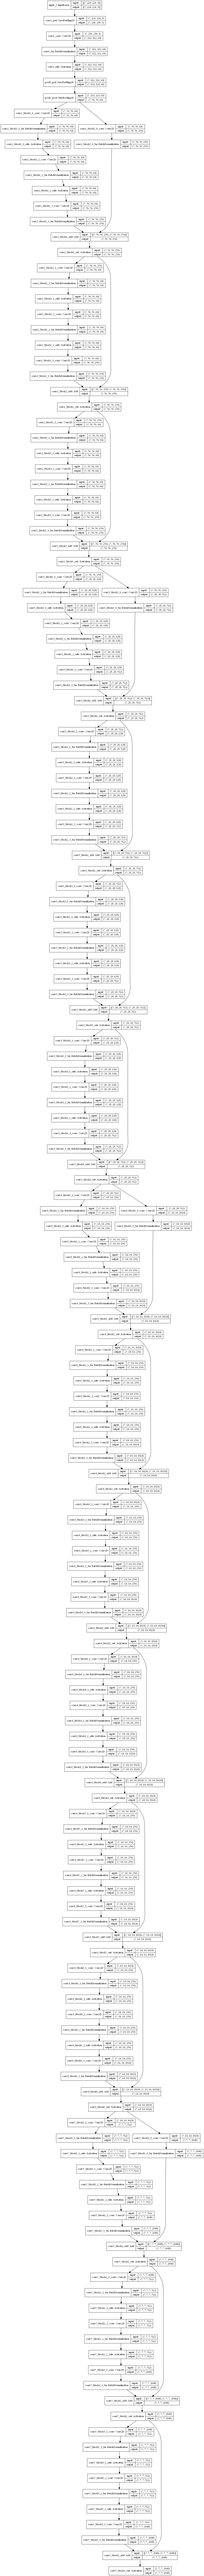

In [8]:
# load the resnet50 model
print(f'[INFO] loading the network.....')
model = ResNet50(weights="imagenet",
                 include_top=False,
                 input_shape=(224, 224, 3))
layer = model.layers[-1]
last_layer_out_shape = layer.output_shape[-1] * \
                       layer.output_shape[-2] * \
                       layer.output_shape[-3]
plot_model(model, show_shapes=True)

In [9]:
# init the the dataset for storing the extracted features
dataset = HDF5DatasetWriter(dims=(len(image_paths), last_layer_out_shape),
                            outputPath=args["output"],
                            dataKey="extracted_features",
                            bufSize=args["buffer_size"])
dataset.storeClassLabels(le.classes_)

In [10]:
# init a progressbar
widgets = ["Extracting Features :", " ",  progressbar.Percentage(), " ",
           progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(image_paths), widgets=widgets).start()


# now extract the features
# loop over batches
for i in range(0, len(image_paths), batch_size):

    batch_paths = image_paths[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    batch_images = []

    #  a batch of paths extracted, now loop over them
    for j, image_path in enumerate(batch_paths):
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        batch_images.append(image)

    # pass images thru network
    batch_images = np.vstack(batch_images)
    extracted_features = model.predict(batch_images, batch_size=batch_size)

    # reshape the features
    extracted_features = extracted_features.\
        reshape((extracted_features.shape[0], last_layer_out_shape))

    # add features to dataset
    dataset.add(extracted_features, batch_labels)
    pbar.update(i)

# close connections
dataset.close()
pbar.finish()

Extracting Features : 100% |###################################| Time:  0:36:34
